In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Regresión Lasso y Ridge
**Facundo A. Lucianna - Inteligencia Artificial - CEIA - FIUBA**

En el notebook anterior realizamos un procedimiento de selección de modelos, el cual es un proceso tedioso y, en el caso de tener muchas más variables, puede volverse inmanejable. Veamos si podemos obtener resultados similares utilizando **regularización de Ridge o Lasso**, o incluso si podemos mejorar los resultados reduciendo el error de varianza.

Carguemos el dataset completo:

In [2]:
dataset = pd.read_csv("datasets/50_Startups.csv") 

Dado que necesitamos entrenar varios modelos, primero realizaremos la separación del conjunto de datos y el preprocesamiento de los datos:

In [3]:
from sklearn.model_selection import train_test_split

X = dataset.drop(columns='Profit')
y = dataset["Profit"]

# Usamos random_state=42 para asegurar que el split del dataset sea consistente con el notebook anterior
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Ahora, armemos el preprocesador que aplicará el `One-Hot Encoding` a las variables categóricas y la estandarización a las variables numéricas.

Es importante notar que, a diferencia de la regresión lineal, la estandarización o normalización de las variables numéricas es un paso obligatorio en estas regresiones:

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_columns = ['State']
numerical_columns = ['R&D Spend', 'Administration', 'Marketing Spend']

# Creamos el preprocesamiento para las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns), 
        ('num', StandardScaler(), numerical_columns)   
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)

Para facilitar el siguiente trabajo, transformamos las salidas del preprocesador en un dataframe:

In [5]:
X_train_processed = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

X_train_processed.head()

,cat__State_Florida,cat__State_New York,num__R&D Spend,num__Administration,num__Marketing Spend
0,0.0,0.0,1.309487,0.946637,-0.855429
1,1.0,0.0,-0.966618,-1.507490,-0.536649
2,1.0,0.0,-1.533444,-0.285870,0.613821
3,0.0,0.0,-1.561500,0.484311,-1.963166
4,0.0,1.0,0.880982,-0.018786,0.307319


En scikit-learn tenemos disponibles las dos regresiones: [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) y [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

In [6]:
from sklearn.linear_model import Ridge, Lasso

Cuando utilizamos estos modelos, tenemos un hiperparámetro $\alpha$ que debemos predefinir para encontrar el punto de mejor rendimiento en estas regresiones. Recordemos que este parámetro controla la magnitud de la penalización en los coeficientes del modelo. A medida que aumentamos $\alpha$, los coeficientes se van reduciendo hacia cero, lo que implica mayor regularización y menos sobreajuste.

Veamos cómo los coeficientes cambian en función de $\alpha$:

In [7]:
from sklearn.linear_model import LinearRegression

coeffs_lasso = np.zeros([5000, 5])
coeffs_ridge = np.zeros([5000, 5])

alpha_array_plot = np.arange(0, 10000, 2)

# Calculamos los coeficientes para diferentes valores de lambda
for index, alpha in enumerate(alpha_array_plot):

    # Creamos los modelos
    lasso_model = Lasso(alpha=alpha)
    ridge_model = Ridge(alpha=alpha)

    # Si alpha es cero, significa que es una regresión lineal
    if index == 0:
        lasso_model = LinearRegression()
        ridge_model = LinearRegression()

    # Los entrenamos
    lasso_model.fit(X_train_processed, y_train)
    ridge_model.fit(X_train_processed, y_train)

    # Guardamos los coeficientes de las regresiones
    coeffs_lasso[index, :] = lasso_model.coef_.copy()
    coeffs_ridge[index, :] = ridge_model.coef_.copy()

Ahora, armemos un gráfico con la evolución de los valores de los coeficientes en función de $\alpha$. Como hemos aplicado la estandarización, los valores son comparables:

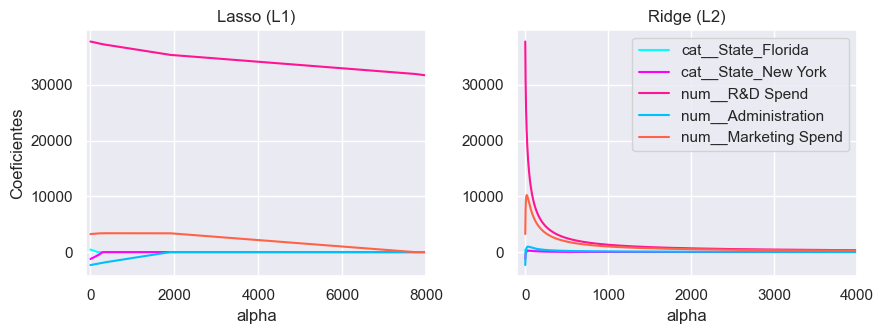

In [8]:
num_lines = coeffs_lasso.shape[1]
colormap = ["#00FFFF", "#FF00FF", "#FF1493", "#00BFFF", "#FF6347"]

f, ax = plt.subplots(1, 2, figsize=(9, 3.5))

for i in range(num_lines):
    ax[0].plot(alpha_array_plot, coeffs_lasso[:, i], color=colormap[i])
    ax[1].plot(alpha_array_plot, coeffs_ridge[:, i], label=X_train_processed.columns[i], color=colormap[i])

ax[1].legend()
ax[0].set_xlim([-100, 8000])
ax[1].set_xlim([-100, 4000])

ax[0].set_ylabel("Coeficientes")
ax[0].set_xlabel("alpha")
ax[1].set_xlabel("alpha")

ax[0].set_title("Lasso (L1)")
ax[1].set_title("Ridge (L2)")

plt.tight_layout()

Vemos los efectos de las regresiones, donde en la **regresión de Ridge** todos los coeficientes tienden a cero, aunque nunca llegan a ser exactamente cero. Mientras tanto, en la **regresión de Lasso**, los diferentes coeficientes se van haciendo cero de manera progresiva, y curiosamente, en el mismo orden en que realizamos la selección mediante eliminación hacia atrás.

### Buscando los mejores valores de $\alpha$

Para encontrar los mejores valores de $\alpha$, vamos a utilizar validación cruzada, que nos permite realizar la búsqueda de hiperparámetros (tema que se profundizará más adelante en el curso de Aprendizaje de Máquina).

Para realizar la validación cruzada, utilizamos el objeto `KFold` de [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html), que se encarga de dividir al azar el conjunto de datos en K subconjuntos. Para poder hacer la selección, necesitamos una métrica que queramos calcular, y en este caso usaremos el MAE. Así, mediante un bucle, asignamos un valor a $\alpha$, entrenamos K modelos usando validación cruzada y calculamos el MAE medio de esos K modelos. Una vez finalizado el bucle, seleccionamos el valor de $\alpha$ que mejor ajuste los resultados.

> ⚠️ **Nota**: Obsérvese que no usamos el conjunto de datos de evaluación.

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

alpha_array = np.arange(0, 1000, 0.25)

# Validación cruzada de 3 folds
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Donde vamos a almacenar los errores
cv_ridge_errors = []
cv_lasso_errors = []

# Búsqueda del mejor alpha usando un loop
for alpha in alpha_array:
    fold_ridge_errors = []
    fold_lasso_errors = []

    # Realizar la validación cruzada
    for train_idx, val_idx in kf.split(X_train_processed):
        X_train_fold, X_val_fold = X_train_processed.iloc[train_idx, :], X_train_processed.iloc[val_idx, :]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
        # Crear y entrenar el modelo de Ridge
        ridge = Ridge(alpha=alpha)
        lasso = Lasso(alpha=alpha)
        if alpha == 0:
            ridge = LinearRegression()
            lasso = LinearRegression()
        
        ridge.fit(X_train_fold, y_train_fold)
        lasso.fit(X_train_fold, y_train_fold)

        # Hacer las predicciones sobre el fold de validación
        y_pred_ridge = ridge.predict(X_val_fold)
        y_pred_lasso = lasso.predict(X_val_fold)

        # Calcular el error cuadrático medio para el fold
        mse_ridge = mean_absolute_error(y_val_fold, y_pred_ridge)
        mse_lasso = mean_absolute_error(y_val_fold, y_pred_lasso)
        fold_ridge_errors.append(mse_ridge)
        fold_lasso_errors.append(mse_lasso)

    # Calcular el error medio para este alpha
    cv_ridge_errors.append(np.mean(fold_ridge_errors))
    cv_lasso_errors.append(np.mean(fold_lasso_errors))

# Mostramos cual es el mejor valor de alpha para cada caso
best_alpha_ridge = alpha_array[np.argmin(cv_ridge_errors)]
best_alpha_lasso = alpha_array[np.argmin(cv_lasso_errors)]
print(f"El mejor valor de alpha para Ridge es: {best_alpha_ridge}")
print(f"El mejor valor de alpha para Lasso es: {best_alpha_lasso}")

El mejor valor de alpha para Ridge es: 0.5
El mejor valor de alpha para Lasso es: 640.5


Este proceso puede ser lento debido a la gran cantidad de ciclos `for`. `scikit-learn` nos ofrece soluciones más eficientes para aplicar este proceso, como [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), así como otras técnicas más sofisticadas que permiten la ejecución en paralelo. Como se mencionó antes, en otras materias se profundizará en estos detalles.

----

### Entrenamiento y evaluación de modelos

Con los valores de $\alpha$ seleccionados, vamos a entrenar los modelos y evaluar su rendimiento con el conjunto de evaluación.

In [10]:
from sklearn.pipeline import Pipeline

categorical_columns = ['State']
numerical_columns = ['R&D Spend', 'Administration', 'Marketing Spend']

# Creamos el preprocesamiento para las columnas de ambos modelos
preprocessor_ridge = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ]
)
preprocessor_lasso = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ]
)

# Creamos los pipelines
pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor_ridge),
    ('regressor', Ridge(alpha=best_alpha_ridge))  # Aplicamos la regresión lineal
])
pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor_lasso),
    ('regressor', Lasso(alpha=best_alpha_lasso))  # Aplicamos la regresión lineal
])

pipeline_ridge.fit(X_train, y_train)
pipeline_lasso.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['State']),
                                                 ('num', StandardScaler(),
                                                  ['R&D Spend',
                                                   'Administration',
                                                   'Marketing Spend'])])),
                ('regressor', Lasso(alpha=np.float64(640.5)))])

Ahora evaluamos ambos modelos:

In [11]:
from sklearn.metrics import (r2_score, mean_absolute_error, 
                             mean_squared_error, root_mean_squared_error, 
                             mean_absolute_percentage_error)

# Evaluamos el modelo de Ridge
y_pred = pipeline_ridge.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Regresión de Ridge")
print("------------------")
print("R-cuadrado en test:", round(r2, 3))
print("Error absoluto medio:", round(mae, 3))
print("Error cuadrático medio:", round(mse, 3))
print("Raíz de error cuadrático medio:", round(rmse, 3))
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")

Regresión de Ridge
------------------
R-cuadrado en test: 0.939
Error absoluto medio: 7449.025
Error cuadrático medio: 85321809.127
Raíz de error cuadrático medio: 9236.981
Error absoluto porcentual medio: 8.88%


In [12]:
# Evaluamos el modelo de Lasso
y_pred = pipeline_lasso.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Regresión de Lasso")
print("------------------")
print("R-cuadrado en test:", round(r2, 3))
print("Error absoluto medio:", round(mae, 3))
print("Error cuadrático medio:", round(mse, 3))
print("Raíz de error cuadrático medio:", round(rmse, 3))
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")

Regresión de Lasso
------------------
R-cuadrado en test: 0.947
Error absoluto medio: 6878.502
Error cuadrático medio: 75145932.883
Raíz de error cuadrático medio: 8668.675
Error absoluto porcentual medio: 8.35%


#### Comparación de modelos:

Comparamos estos resultados con los obtenidos anteriormente:

|                    | $R^2$      | MAE ($)   | RMSE ($) | MAPE (%) |
|--------------------|------------|-----------|----------|----------|
| Baseline           | -0.005     | 30301     | 3759     | 35.79    |
| Modelo completo    | 0.94       | 7395      | 9210     | 8.93     |
| Modelo simple      | 0.953      | 6449      | 8157     | 7.34     |
| Regresión de Lasso | 0.947      | 6878      | 8668     | 8.35     |
| Regresión de Ridge | 0.939      | 7449      | 9236     | 8.88     |

Observamos que la regresión de Ridge no mejora el resultado obtenido. Esto se debe a que el problema que tenemos no presenta problemas de varianza en los errores. La **regresión Ridge** tiene más sentido cuando tenemos muchos atributos y pocas observaciones. Aunque ya lo habíamos notado anteriormente, ahora lo hemos validado.

Por otro lado, la **regresión de Lasso** presenta resultados interesantes. Aunque es mejor que la regresión lineal con todos los atributos, no supera al modelo más simple. La regresión de Lasso realiza selección de atributos, por lo que veamos los valores de los coeficientes:

In [13]:
print(f"Los valores de los coeficientes de Lasso son {np.round(pipeline_lasso.named_steps['regressor'].coef_, 2)}")

Los valores de los coeficientes de Lasso son [    0.      -0.   36841.46 -1482.26  3382.13]


Vemos que los coeficientes correspondientes a la ubicación de las startups son cero, lo que significa que el modelo no tiene en cuenta esos dos valores. Por lo tanto, se puede utilizar el modelo sin esos atributos.

Si observamos la gráfica del tamaño de los coeficientes en función del valor de $\alpha$:

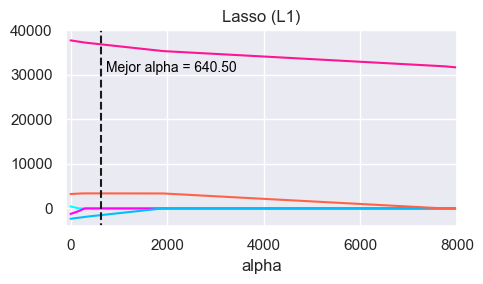

In [14]:
plt.figure(figsize=(5, 3))

num_lines = coeffs_lasso.shape[1]
colors = ["#00FFFF", "#FF00FF", "#FF1493", "#00BFFF", "#FF6347"]

for i in range(coeffs_lasso.shape[1]):
    plt.plot(alpha_array_plot, coeffs_lasso[:, i], label=X_train_processed.columns[i], color=colors[i])

plt.plot([best_alpha_lasso, best_alpha_lasso], [-5000, 100_000], 'k--')

plt.text(best_alpha_lasso + 100, 30_000, f'Mejor alpha = {best_alpha_lasso:.2f}', color='black', 
         verticalalignment='bottom', horizontalalignment='left', fontsize=10)


plt.ylim([-4000, 40_000])
plt.xlim([-100, 8000])
plt.xlabel("alpha")
plt.title("Lasso (L1)")

plt.tight_layout();

De la gráfica podemos notar que la **regresión Lasso** no puede encontrar el mejor modelo usando solo los dos atributos `"R&D Spend"` y `"Marketing Spend"`, porque la penalización para hacer que el coeficiente de `"Administration"` sea cero afecta significativamente a los valores de los coeficientes de las columnas `"R&D Spend"` y `"Marketing Spend"`. Como resultado, los modelos Lasso sin el atributo `"Administration"` rinden peor que la regresión lineal obtenida mediante selección de modelo. Sin embargo, las métricas nos muestran que la diferencia no es muy grande, y el proceso de encontrar y entrenar este modelo es más sencillo que cuando realizamos selección de modelos. Esto se vuelve más notorio cuando hay muchos atributos.

Finalmente, guardemos el modelo:

In [15]:
import joblib

with open('lasso_50_startup.pkl', 'wb') as archivo:
    joblib.dump(pipeline_lasso, archivo)